In [1]:
import sys
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import numpy as np
import SimpleITK as sitk
import radiomics as rad
import six
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.abspath('src/'))
from data.lungdataset import LungData
#from utils import extract_firstlevel_features

plt.rcParams.update({"axes.facecolor" : "white",
                     "axes.edgecolor":  "black",
                     "patch.facecolor": "white",
                     "figure.facecolor" : "white"}) # prevent the transparency 

In [2]:
rootdir = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh1_A"
ld = LungData(rootdir)
medical_df = ld.raw_ehd
ehd = ld.process_features(return_df=True)
#ld.as_dataframe()

print(medical_df.shape, "---", ehd.shape)

(1279, 130) --- (1279, 98)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_absolute_error, balanced_accuracy_score, f1_score, accuracy_score, make_scorer, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer

random_state = 42
rnd_state = random_state

In [4]:
medical_df["y"] = ld.ml_target_df["y"].copy()
medical_df.head()

,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,is_icu,was_ventilated,invasive_vent_days,...,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy,y
0,A917122,positive,discharged,"[74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,...,39.0,128.0,NaN,NaN,NaN,NaN,False,True,apixaban,0
1,A387558,positive,deceased,"[74,90]",MALE,1/1/1901,Inpatient Visit,True,No,NaN,...,NaN,199.0,NaN,NaN,NaN,NaN,True,True,apixaban,6
2,A968238,positive,deceased,"[74,90]",MALE,1/5/1901,Inpatient Visit,True,Yes,28.0,...,54.0,134.0,NaN,NaN,NaN,NaN,False,True,not documented,7
3,A642300,positive,deceased,"[74,90]",FEMALE,12/31/1900,Inpatient Visit,True,Yes,9.0,...,NaN,246.0,NaN,NaN,NaN,NaN,False,True,not documented,7
4,A205701,positive,discharged,"[59,74]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,...,32.0,106.0,NaN,NaN,NaN,NaN,False,False,not documented,0


In [5]:
# No records without missing data
medical_df.dropna()

,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,is_icu,was_ventilated,invasive_vent_days,...,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy,y


Text(0.5, 1.0, 'Missing data pattern')

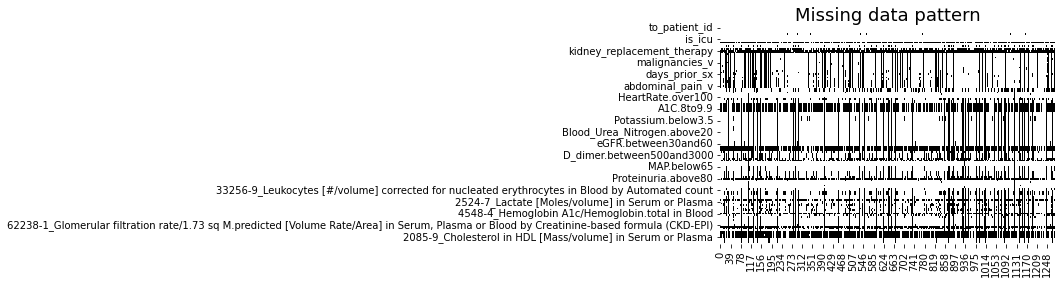

In [6]:
g = sns.heatmap(medical_df.isna().T, cmap="binary", cbar=False)
g.set_title("Missing data pattern", size=18)

<AxesSubplot:>

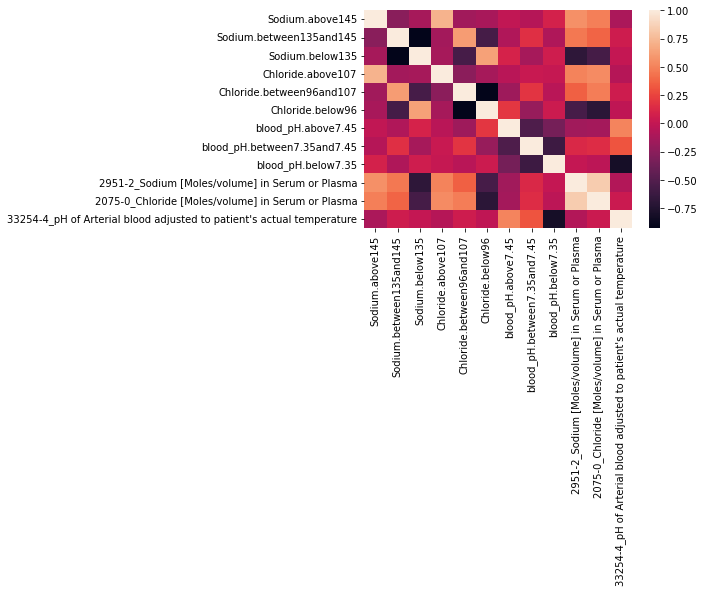

In [7]:
sns.heatmap(medical_df.filter(regex="pH|Chloride|Sodium").apply(pd.to_numeric).corr())

In [8]:
filtered = medical_df.filter(regex="above|between|\dto\d|below|over").columns
# given we have the original column we should drop these, they are redundant
drop_cand = ['blood_pH.above7.45', "blood_pH.between7.35and7.45", "blood_pH.below7.35", 
  'Chloride.above107', 'Chloride.between96and107', 'Chloride.below96',
  'Sodium.above145', 'Sodium.between135and145', 'Sodium.below135',
  'Potassium.above5.2', 'Potassium.between3.5and5.2', 'Potassium.below3.5',
  'Bicarbonate.above31', 'Bicarbonate.between21and31', 'Bicarbonate.below21',
  'A1C.over6.5', 'A1C.under6.5', 'A1C.6.6to7.9', 'A1C.8to9.9', 'A1C.over10',
  'Blood_Urea_Nitrogen.above20', 'Blood_Urea_Nitrogen.between5and20', 'Blood_Urea_Nitrogen.below5',
  'Creatinine.above1.2', 'Creatinine.between0.5and1.2', 'Creatinine.below0.5',
  'Troponin.above0.01',
  'D_dimer.above3000', 'D_dimer.between500and3000', 'D_dimer.below500',
  'procalcitonin.below0.25', 'procalcitonin.between0.25and0.5', 'procalcitonin.above0.5',
  'ferritin.above1k',
  'ESR.above30', # Erythrocyte sedimentation rate
  'Lymphocytes.under1k',
  'BMI.over30', 'BMI.over35',
  'SBP.above139', 'SBP.below120','SBP.between120and139', # systolic blood pressure
  'MAP.below65', 'MAP.between65and90', 'MAP.above90', # Oxygen saturation in Arterial blood by Pulse oximetry
  'eGFR.above60', 'eGFR.below30', 'eGFR.between30and60', # estimated Glomerular filtration rate -> estimate how well your kidneys are filtering certain agents
  'Aspartate.over40', 
  'HeartRate.over100', 
  'Alanine.over60',
  'temperature.over38',
]

set(filtered) - set(drop_cand)

{'Microscopic_hematuria.above2', 'Proteinuria.above80', 'Respiration.over24'}

In [9]:
medical_df.filter(regex="above|between|\dto\d|below|over").columns

Index(['BMI.over30', 'BMI.over35', 'temperature.over38', 'Respiration.over24',
       'HeartRate.over100', 'Aspartate.over40', 'Alanine.over60',
       'A1C.over6.5', 'A1C.6.6to7.9', 'A1C.8to9.9', 'A1C.over10',
       'Sodium.above145', 'Sodium.between135and145', 'Sodium.below135',
       'Potassium.above5.2', 'Potassium.between3.5and5.2',
       'Potassium.below3.5', 'Chloride.above107', 'Chloride.between96and107',
       'Chloride.below96', 'Bicarbonate.above31', 'Bicarbonate.between21and31',
       'Bicarbonate.below21', 'Blood_Urea_Nitrogen.above20',
       'Blood_Urea_Nitrogen.between5and20', 'Blood_Urea_Nitrogen.below5',
       'Creatinine.above1.2', 'Creatinine.between0.5and1.2',
       'Creatinine.below0.5', 'eGFR.above60', 'eGFR.between30and60',
       'eGFR.below30', 'blood_pH.above7.45', 'blood_pH.between7.35and7.45',
       'blood_pH.below7.35', 'Troponin.above0.01', 'D_dimer.above3000',
       'D_dimer.between500and3000', 'D_dimer.below500', 'ESR.above30',
       'Microsco

In [10]:
nc = ld._numeric_cols
bc = ld._binary_cols
diff = set(bc) - set(drop_cand)
print(len(diff))
medical_df[diff].dropna()

25


,abdominal_pain_v,acei_v,pulseOx.under90,fever_v,malignancies_v,cough_v,dm_v,antibiotics_use_v,dyspnea_admission_v,other_lung_disease_v,...,diarrhea_v,therapeutic.exnox.Boolean,Proteinuria.above80,arb_v,copd_v,ckd_v,htn_v,nausea_v,Microscopic_hematuria.above2,Respiration.over24
33,No,No,False,Yes,Yes,Yes,No,No,Yes,No,...,No,True,True,No,No,No,No,No,False,False
44,Yes,No,False,No,No,Yes,No,Yes,No,No,...,Yes,False,False,No,No,No,Yes,No,False,False
63,No,Yes,True,Yes,No,Yes,Yes,Yes,Yes,Yes,...,Yes,True,True,No,Yes,No,No,No,True,True
108,No,No,False,Yes,Yes,Yes,No,No,Yes,No,...,No,False,False,No,No,No,No,Yes,False,False
127,No,No,False,Yes,No,No,No,No,Yes,No,...,No,True,True,No,No,No,No,No,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,No,No,True,Yes,No,Yes,No,No,Yes,No,...,Yes,True,True,No,No,No,No,No,False,False
1229,No,No,False,Yes,No,Yes,No,No,Yes,No,...,No,True,False,No,No,No,No,No,False,True
1231,No,No,False,Yes,No,Yes,No,No,Yes,No,...,No,False,False,No,No,No,No,No,True,False
1257,No,No,True,Yes,No,Yes,No,No,Yes,No,...,Yes,True,True,No,No,No,Yes,No,False,True


In [11]:
na_zeros = ["invasive_vent_days", #days are NaN for patients not ventilated
            "kidney_replacement_therapy", "kidney_transplant", #either 1 or NaN in the whole dataset - treat as binary
            ]
medical_df[na_zeros] = medical_df[na_zeros].fillna(0)

pd.DataFrame(medical_df.drop(drop_cand, axis=1).isnull().sum()).sort_values(0, ascending=False).T

,Proteinuria.above80,33254-4_pH of Arterial blood adjusted to patient's actual temperature,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,4548-4_Hemoglobin A1c/Hemoglobin.total in Blood,2157-6_Creatine kinase [Enzymatic activity/volume] in Serum or Plasma,Microscopic_hematuria.above2,Urine.protein,...,Acute.Kidney.Injury..during.hospitalization.,length_of_stay,invasive_vent_days,was_ventilated,is_icu,visit_concept_name,visit_start_datetime,age.splits,last.status,y
0,1080,1060,996,995,993,982,875,855,787,779,...,0,0,0,0,0,0,0,0,0,0


In [12]:
na_zeros = ["invasive_vent_days", #days are NaN for patients not ventilated
            "kidney_replacement_therapy", "kidney_transplant", #either 1 or NaN in the whole dataset - treat as binary
            ]
medical_df[na_zeros] = medical_df[na_zeros].fillna(0)

In [13]:
r = pd.DataFrame()
ldict = ld.ml_target_df[["y", "Outcome"]].set_index("y").to_dict()

for ml in medical_df["y"].unique():
    nans = medical_df[medical_df["y"] == ml].isnull().sum().max()
    length = medical_df[medical_df["y"] == ml].shape[0]
    prop = medical_df[medical_df["y"] == ml].isnull().sum().max() / medical_df[medical_df["y"] == ml].shape[0]

    r.at[ml, "Outcome"] = ldict["Outcome"][ml]
    r.at[ml, "Rows with NaNs"] = nans
    r.at[ml, "Records per label"] = length
    r.at[ml, "prop"] = prop

print(r.reset_index().rename(columns={"index":"label"}).sort_values(by="label").round(2).to_latex(index=False))
r.reset_index().rename(columns={"index":"label"}).sort_values(by="label").round(2)

\begin{tabular}{rlrrr}
\toprule
 label &                     Outcome &  Rows with NaNs &  Records per label &  prop \\
\midrule
     0 &         Hospitalized (only) &           901.0 &              948.0 &  0.95 \\
     1 &                  Ventilated &             9.0 &               11.0 &  0.82 \\
     2 &                         ICU &            38.0 &               46.0 &  0.83 \\
     3 &                  ICU + Vent &            89.0 &              100.0 &  0.89 \\
     4 &                    Deceased &            51.0 &               61.0 &  0.84 \\
     5 &       Deceased + Ventilated &             2.0 &                2.0 &  1.00 \\
     6 &              Deceased + ICU &             9.0 &               11.0 &  0.82 \\
     7 & Deceased + ICU + Ventilated &            78.0 &              100.0 &  0.78 \\
\bottomrule
\end{tabular}



,label,Outcome,Rows with NaNs,Records per label,prop
0,0,Hospitalized (only),901.0,948.0,0.95
7,1,Ventilated,9.0,11.0,0.82
5,2,ICU,38.0,46.0,0.83
4,3,ICU + Vent,89.0,100.0,0.89
3,4,Deceased,51.0,61.0,0.84
6,5,Deceased + Ventilated,2.0,2.0,1.00
1,6,Deceased + ICU,9.0,11.0,0.82
2,7,Deceased + ICU + Ventilated,78.0,100.0,0.78


In [14]:
pd.DataFrame(medical_df.isnull().sum()).sort_values(0, ascending=False)[:25]

,0
Proteinuria.above80,1080
33254-4_pH of Arterial blood adjusted to patient's actual temperature,1060
blood_pH.between7.35and7.45,1060
blood_pH.above7.45,1060
blood_pH.below7.35,1060
13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,996
13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,995
2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,993
2571-8_Triglyceride [Mass/volume] in Serum or Plasma,982
A1C.over6.5,875


In [15]:
d = medical_df[medical_df["blood_pH.below7.35"].isna()]["y"].value_counts().to_dict()
da = medical_df[medical_df["A1C.8to9.9"].isna()]["y"].value_counts().to_dict()
dbmi = medical_df[medical_df["BMI.over30"].isna()]["y"].value_counts().to_dict()

for ml, cnt in d.items():
    r.at[ml, "pH_na"] = cnt
    r.at[ml, "pH"] = cnt / r.loc[ml, "Records per label"]

for ml, cnt in da.items():
    r.at[ml, "A1C_na"] = cnt
    r.at[ml, "A1C"] = cnt / r.loc[ml, "Records per label"]

for ml, cnt in dbmi.items():
    r.at[ml, "BMI_na"] = cnt
    r.at[ml, "BMI"] = cnt / r.loc[ml, "Records per label"]

print(r.reset_index().rename(columns={"index":"label"}).sort_values(by="label").round(2).to_latex(index=False))
r.reset_index().rename(columns={"index":"label"}).sort_values(by="label").round(2)

\begin{tabular}{rlrrrrrrrrr}
\toprule
 label &                     Outcome &  Rows with NaNs &  Records per label &  prop &  pH\_na &   pH &  A1C\_na &  A1C &  BMI\_na &  BMI \\
\midrule
     0 &         Hospitalized (only) &           901.0 &              948.0 &  0.95 &  901.0 & 0.95 &   703.0 & 0.74 &   317.0 & 0.33 \\
     1 &                  Ventilated &             9.0 &               11.0 &  0.82 &    4.0 & 0.36 &     8.0 & 0.73 &     3.0 & 0.27 \\
     2 &                         ICU &            38.0 &               46.0 &  0.83 &   29.0 & 0.63 &    21.0 & 0.46 &    11.0 & 0.24 \\
     3 &                  ICU + Vent &            89.0 &              100.0 &  0.89 &   37.0 & 0.37 &    53.0 & 0.53 &    25.0 & 0.25 \\
     4 &                    Deceased &            51.0 &               61.0 &  0.84 &   48.0 & 0.79 &    38.0 & 0.62 &    12.0 & 0.20 \\
     5 &       Deceased + Ventilated &             2.0 &                2.0 &  1.00 &    NaN &  NaN &     1.0 & 0.50 &     1.0 &

,label,Outcome,Rows with NaNs,Records per label,prop,pH_na,pH,A1C_na,A1C,BMI_na,BMI
0,0,Hospitalized (only),901.0,948.0,0.95,901.0,0.95,703.0,0.74,317.0,0.33
7,1,Ventilated,9.0,11.0,0.82,4.0,0.36,8.0,0.73,3.0,0.27
5,2,ICU,38.0,46.0,0.83,29.0,0.63,21.0,0.46,11.0,0.24
4,3,ICU + Vent,89.0,100.0,0.89,37.0,0.37,53.0,0.53,25.0,0.25
3,4,Deceased,51.0,61.0,0.84,48.0,0.79,38.0,0.62,12.0,0.20
6,5,Deceased + Ventilated,2.0,2.0,1.00,NaN,NaN,1.0,0.50,1.0,0.50
1,6,Deceased + ICU,9.0,11.0,0.82,1.0,0.09,6.0,0.55,2.0,0.18
2,7,Deceased + ICU + Ventilated,78.0,100.0,0.78,40.0,0.40,45.0,0.45,29.0,0.29


In [16]:
print(r.reset_index().rename(columns={"index":"label"}).sort_values(by="label")[["label", "Outcome", "pH", "A1C", "BMI"]].round(2).to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
 label &                     Outcome &   pH &  A1C &  BMI \\
\midrule
     0 &         Hospitalized (only) & 0.95 & 0.74 & 0.33 \\
     1 &                  Ventilated & 0.36 & 0.73 & 0.27 \\
     2 &                         ICU & 0.63 & 0.46 & 0.24 \\
     3 &                  ICU + Vent & 0.37 & 0.53 & 0.25 \\
     4 &                    Deceased & 0.79 & 0.62 & 0.20 \\
     5 &       Deceased + Ventilated &  NaN & 0.50 & 0.50 \\
     6 &              Deceased + ICU & 0.09 & 0.55 & 0.18 \\
     7 & Deceased + ICU + Ventilated & 0.40 & 0.45 & 0.29 \\
\bottomrule
\end{tabular}



### KNN vs Iterative (vs MI)

In [80]:
print(len(ld._drop_categorical))
top_misses = pd.DataFrame(medical_df.drop(ld._drop_categorical, axis=1).isna().sum()).sort_values(by=0, ascending=False)[:20].index
top_misses = list(top_misses)
top_misses.remove("Urine.protein")
pd.DataFrame(medical_df.drop(ld._drop_categorical, axis=1).isna().sum()).sort_values(by=0, ascending=False)[:25]

51


,0
Proteinuria.above80,1080
33254-4_pH of Arterial blood adjusted to patient's actual temperature,1060
13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,996
13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,995
2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,993
2571-8_Triglyceride [Mass/volume] in Serum or Plasma,982
4548-4_Hemoglobin A1c/Hemoglobin.total in Blood,875
2157-6_Creatine kinase [Enzymatic activity/volume] in Serum or Plasma,855
Microscopic_hematuria.above2,787
Urine.protein,779


In [485]:
ehd_nn = ld.process_features(return_df=True)
print(ehd_nn.shape)

ehd_it = ld.process_features(return_df=True, numeric_mode="iterative")
print(ehd_it.shape)

ehd_mi = ld.process_features(return_df=True, numeric_mode="mi", mi_val=0, binary_mode="mi")
print(ehd_mi.shape)

ehd_mean = ld.process_features(return_df=True, numeric_mode="mean", binary_mode="mean")
print(ehd_mean.shape)

ehd_med = ld.process_features(return_df=True, numeric_mode="median", binary_mode="median")
print(ehd_med.shape)


(1279, 78)
(1279, 78)
(1279, 78)
(1279, 78)
(1279, 78)


In [481]:
medical_df["Creatine kinase [Enzymatic activity/volume] in Serum or Plasma"]

0         NaN
1         NaN
2       244.0
3       833.0
4        25.0
        ...  
1274      NaN
1275    246.0
1276      NaN
1277    896.0
1278      NaN
Name: Creatine kinase [Enzymatic activity/volume] in Serum or Plasma, Length: 1279, dtype: float64

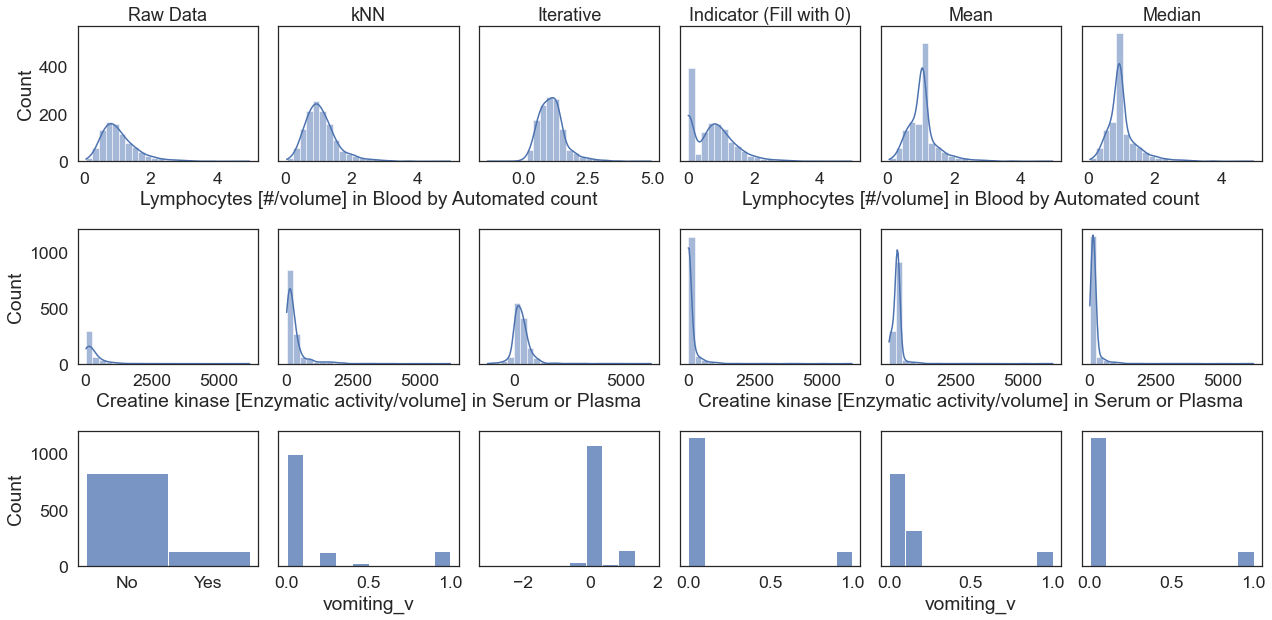

In [493]:
feats = ["Lymphocytes [#/volume] in Blood by Automated count",
        "Creatine kinase [Enzymatic activity/volume] in Serum or Plasma",
        "vomiting_v"]

#sns.set_theme()
#sns.set(style="white")
sns.set(style="white", font_scale=1.6)  # crazy big
dfs = [medical_df, ehd_nn, ehd_it, ehd_mi, ehd_mean, ehd_med]
methods = ["Raw Data", "kNN", "Iterative", "Indicator (Fill with 0)", "Mean", "Median"]
fig,ax = plt.subplots(len(feats), len(dfs), figsize=(18,9), 
    sharey="row"
    )

for j, _x in enumerate(feats):
    for i, df in enumerate(dfs):
        if _x.endswith("_v"):
            sns.histplot(data=df, x=_x, 
                    kde=False, bins=10,
                    ax=ax[j,i])
        else:
            sns.histplot(data=df, x=_x, 
                kde=True, bins=25,
                ax=ax[j,i])
        if j == 0:
            ax[j,i].set_title(methods[i], size=18)
        if i not in [1,4]:
            ax[j,i].set_xlabel("")
        elif i in [1,4]:
            if not _x.endswith("_v"):
                ax[j,i].set_xlabel(_x)
            else:
                ax[j,i].set_xlabel(_x)
        if i != 0:
            ax[j,i].set_ylabel("")
fig.tight_layout()
fig.savefig("../thesis/figures/impl/imputation_comp_by_features.png", dpi=320)

Inpatient Visit:
discharged    778
deceased      172
Name: last.status, dtype: int64
Outpatient Visit:
discharged    2
Name: last.status, dtype: int64
Emergency Room Visit:
discharged    325
deceased        2
Name: last.status, dtype: int64


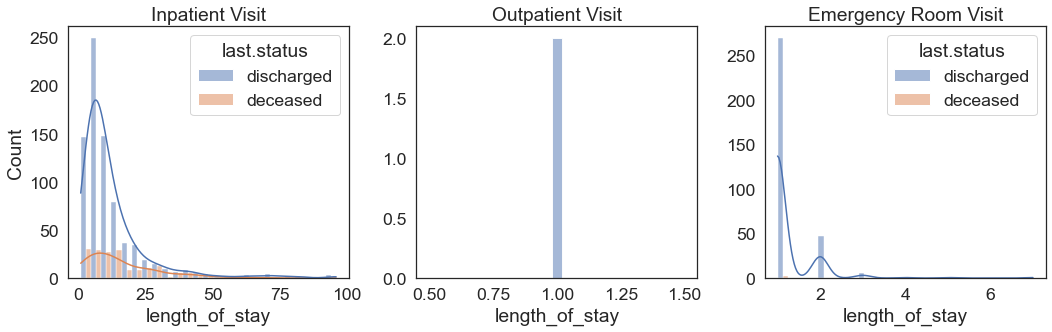

In [170]:
sns.set(style="white", font_scale=1.6)  # crazy big
fig, ax = plt.subplots(1,3, figsize=(15,5))

for i, v in enumerate(["Inpatient Visit", "Outpatient Visit", "Emergency Room Visit"]):
    print(f"{v}:")
    print(medical_df[medical_df["visit_concept_name"] == v]["last.status"].value_counts())
    #print(medical_df[medical_df["visit_concept_name"] == v]["length_of_stay"].value_counts())
    if medical_df[medical_df["visit_concept_name"] == v]["last.status"].nunique() > 1:
        sns.histplot(data=medical_df[medical_df["visit_concept_name"] == v],
            x="length_of_stay", hue="last.status", multiple="dodge",
            ax=ax[i], bins=25, kde=True)
    else:
        sns.histplot(data=medical_df[medical_df["visit_concept_name"] == v],
            x="length_of_stay", #hue="last.status", multiple="dodge",
            ax=ax[i], bins=25, kde=True)
    ax[i].set_title(f"{v}")
    if i != 0:
        ax[i].set_ylabel("")
fig.tight_layout()
fig.savefig("../thesis/figures/expl/visit_vs_length.png", dpi=320)

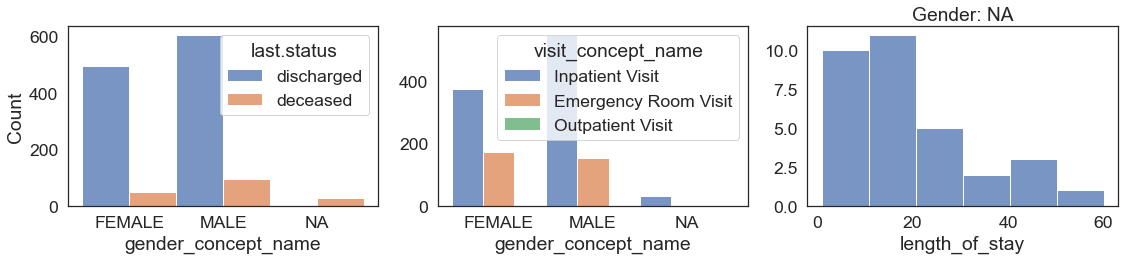

In [178]:
fig,ax = plt.subplots(1,3, figsize=(16,4))

_querydf = medical_df[["gender_concept_name", "visit_concept_name", "last.status", "length_of_stay"]].fillna("NA")

sns.histplot(_querydf,
        x="gender_concept_name", hue="last.status", multiple="dodge", ax=ax[0])

sns.histplot(_querydf,
        x="gender_concept_name", hue="visit_concept_name", multiple="dodge", ax=ax[1])
ax[1].set_ylabel("")
#ax[1].legend()

sns.histplot(_querydf[_querydf["gender_concept_name"] == "NA"],
        x="length_of_stay")
ax[2].set_ylabel("")
ax[2].set_title("Gender: NA")
fig.tight_layout()

fig.savefig("../thesis/figures/expl/genders.png", dpi=320)

In [185]:
medical_df[medical_df["8331-1_Oral temperature"].isna()]

,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,is_icu,was_ventilated,invasive_vent_days,...,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy,y
25,A009815,positive,discharged,"[74,90]",MALE,12/22/1900,Outpatient Visit,False,No,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
34,A632768,positive,deceased,"[59,74]",FEMALE,1/1/1901,Inpatient Visit,True,Yes,6.0,...,88.0,126.0,NaN,NaN,NaN,NaN,True,False,not documented,7
50,A934948,positive,deceased,"[74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,0.0,...,NaN,147.0,NaN,NaN,NaN,NaN,False,False,not documented,4
136,A847272,positive,deceased,"[74,90]",FEMALE,12/17/1900,Inpatient Visit,True,Yes,21.0,...,73.0,273.0,NaN,NaN,NaN,NaN,True,False,not documented,7
138,A086562,positive,discharged,"[18,59]",MALE,12/31/1900,Inpatient Visit,True,Yes,3.0,...,NaN,254.0,NaN,NaN,NaN,NaN,False,False,not documented,3
163,A596625,positive,discharged,"[18,59]",FEMALE,12/24/1900,Inpatient Visit,True,No,0.0,...,NaN,151.0,NaN,NaN,NaN,NaN,False,False,not documented,2
179,A142433,positive,deceased,"[18,59]",NaN,12/21/1900,Inpatient Visit,True,Yes,15.0,...,26.0,184.0,NaN,NaN,NaN,NaN,False,True,not documented,7
208,A808919,positive,discharged,"[59,74]",FEMALE,1/1/1901,Emergency Room Visit,False,No,0.0,...,NaN,110.0,NaN,NaN,NaN,NaN,False,False,not documented,0
223,A120022,positive,deceased,"[74,90]",MALE,1/1/1901,Inpatient Visit,False,No,0.0,...,NaN,123.0,NaN,NaN,NaN,NaN,False,False,not documented,4
256,A362446,positive,deceased,"[18,59]",NaN,12/31/1900,Inpatient Visit,True,Yes,15.0,...,39.0,128.0,41.0,25.0,127.0,27.0,True,True,not documented,7


<AxesSubplot:xlabel='8331-1_Oral temperature', ylabel='Count'>

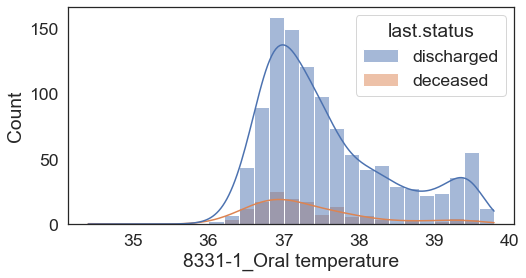

In [196]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
sns.histplot(medical_df, x="8331-1_Oral temperature", hue="last.status", kde=True, ax=ax)

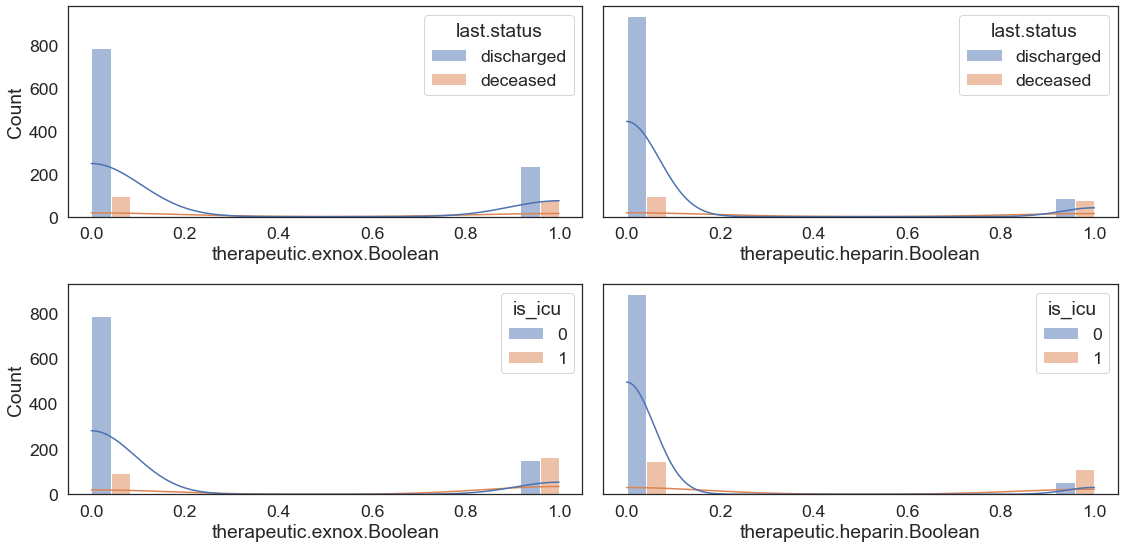

In [237]:
fig,ax = plt.subplots(2,2, figsize=(16,8), sharey="row") 
_querydf = medical_df[["therapeutic.exnox.Boolean", "therapeutic.heparin.Boolean", "last.status", "is_icu"]].replace({False:0, True:1})
j = 0
for i, _c in enumerate(["therapeutic.exnox.Boolean", "therapeutic.heparin.Boolean"]):
    sns.histplot(_querydf, x=_c, hue="last.status", kde=True, ax=ax[j, i], multiple="dodge")
j = 1
for i, _c in enumerate(["therapeutic.exnox.Boolean", "therapeutic.heparin.Boolean"]):
    sns.histplot(_querydf, x=_c, hue="is_icu", kde=True, ax=ax[j,i], multiple="dodge")
fig.tight_layout()

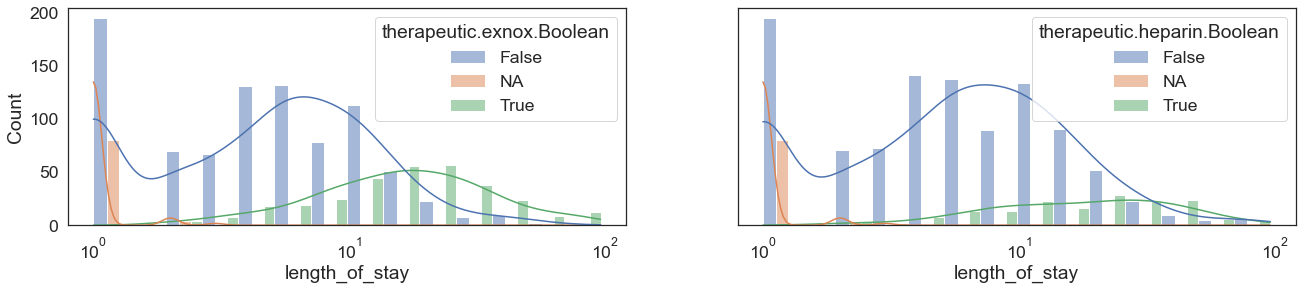

In [238]:
fig,ax = plt.subplots(1,2, figsize=(22,4), sharey=True) 
_querydf = medical_df[["therapeutic.exnox.Boolean", "therapeutic.heparin.Boolean", "last.status", "length_of_stay"]]
for i, _c in enumerate(["therapeutic.exnox.Boolean", "therapeutic.heparin.Boolean"]):
    sns.histplot(data=_querydf.fillna("NA").sort_values(by="length_of_stay"), x="length_of_stay", hue=_c, kde=True, ax=ax[i], bins="fd", multiple="dodge", log_scale=True)

<AxesSubplot:xlabel='Respiratory rate', ylabel='Count'>

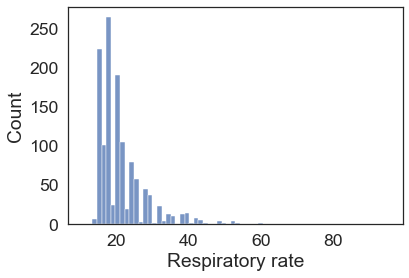

In [496]:
sns.histplot(medical_df["Respiratory rate"], bins="fd")

## Stuff for Chapter 2

In [257]:
medical_df

,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,is_icu,was_ventilated,invasive_vent_days,...,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy,y
0,A917122,positive,discharged,"[74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,0.0,...,39.0,128.0,NaN,NaN,NaN,NaN,False,True,apixaban,0
1,A387558,positive,deceased,"[74,90]",MALE,1/1/1901,Inpatient Visit,True,No,0.0,...,NaN,199.0,NaN,NaN,NaN,NaN,True,True,apixaban,6
2,A968238,positive,deceased,"[74,90]",MALE,1/5/1901,Inpatient Visit,True,Yes,28.0,...,54.0,134.0,NaN,NaN,NaN,NaN,False,True,not documented,7
3,A642300,positive,deceased,"[74,90]",FEMALE,12/31/1900,Inpatient Visit,True,Yes,9.0,...,NaN,246.0,NaN,NaN,NaN,NaN,False,True,not documented,7
4,A205701,positive,discharged,"[59,74]",FEMALE,1/1/1901,Inpatient Visit,False,No,0.0,...,32.0,106.0,NaN,NaN,NaN,NaN,False,False,not documented,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,A758054,positive,discharged,"[18,59]",FEMALE,1/1/1901,Emergency Room Visit,False,No,0.0,...,NaN,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1275,A467564,positive,discharged,"[18,59]",MALE,1/1/1901,Inpatient Visit,False,No,0.0,...,NaN,207.0,NaN,NaN,NaN,NaN,True,False,not documented,0
1276,A779189,positive,discharged,"[18,59]",MALE,12/31/1900,Emergency Room Visit,False,No,0.0,...,NaN,106.0,NaN,NaN,NaN,NaN,False,False,not documented,0
1277,A842970,positive,discharged,"[18,59]",MALE,1/1/1901,Inpatient Visit,False,No,0.0,...,NaN,111.0,NaN,NaN,NaN,NaN,True,False,not documented,0


In [256]:
miss_df = pd.DataFrame(medical_df.isna().sum()).sort_values(by=0)
miss_df[miss_df[0]==0]

,0
to_patient_id,0
kidney_transplant,0
kidney_replacement_therapy,0
Acute.Kidney.Injury..during.hospitalization.,0
length_of_stay,0
invasive_vent_days,0
was_ventilated,0
y,0
visit_concept_name,0
visit_start_datetime,0


In [278]:
for t in ld._targets:
    print(f"{t}:")
    _d = dict(medical_df[t].value_counts())
    print(_d)
    print(round(min(_d.values())/medical_df.shape[0], 3) * 100)

last.status:
{'discharged': 1105, 'deceased': 174}
13.600000000000001
is_icu:
{False: 1022, True: 257}
20.1
was_ventilated:
{'No': 1066, 'Yes': 213}
16.7


---

In [468]:
rootdir = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh1_A"
ld = LungData(rootdir)
medical_df = ld.raw_ehd

In [429]:
for t in ld._targets:
    print(t)
    print(medical_df[medical_df["dm_v"].isna()][t].value_counts())

last.status
discharged    218
deceased       26
Name: last.status, dtype: int64
is_icu
False    212
True      32
Name: is_icu, dtype: int64
was_ventilated
No     221
Yes     23
Name: was_ventilated, dtype: int64


In [474]:
pre_known = ld._pre_known_features
pk_df = medical_df[pre_known]
lab_df = ld.process_features(impute=False, return_df=True, normalize_dates=False, onehot=False)
lab_df = lab_df.drop(ld._targets, axis=1)
print(pk_df.shape, lab_df.shape)

(1279, 26) (1279, 62)


In [439]:
pk_names = pk_df.columns
pk_ = pd.DataFrame()
pk_["feat_short"] = pk_names
pk_["Description"] = ["Age ([18-59; 59-74; 74-90])", "Gender", "Kidney Replacement Therapy", "Kidney Transplant",
                 "Hyptertension (high blood pressure)", "Diabetes", "Coronary Artery Disease",
                 "Heart Failure, Ejection Fraction", "Chronic Kidney Disease", "Cancer/Tumor",
                 "Chronic pulmonary disease", "Other lung disease", "ACE inhibitor - High blood pressure medical treatment", 
                 "ARB - Usage of blood widener", "Antibiotics", "NSAID - Usage of anti-inflammatory drug (aspirin, paracetamol)",
                 "Smoking status", "Cough", "Shortness of breath (Dyspnea)", "Nausea", "Vomiting", "Diarrhea",
                 "Abdominal pain", "Fever", "Oral temperature", "Body Mass Index" ]
pk_.set_index("feat_short", inplace=True)
pk_["NA"] = pd.DataFrame(medical_df.isna().sum()).T[pre_known].T
pk_.reset_index(inplace=True)

In [448]:
print(medical_df.head().filter(regex="BMI").to_latex())

\begin{tabular}{lllr}
\toprule
{} & BMI.over30 & BMI.over35 &  39156-5\_Body mass index (BMI) [Ratio] \\
\midrule
0 &      False &      False &                                  20.94 \\
1 &      False &      False &                                  27.46 \\
2 &      False &      False &                                  29.90 \\
3 &       True &      False &                                  31.45 \\
4 &      False &      False &                                  26.82 \\
\bottomrule
\end{tabular}



In [455]:
cnt = 0
s = ""
for i in pk_["Description"]:
    cnt = cnt+1
    if cnt <4:
        s = s + i + " & "
    else:
        print(s[:-3] + " \\\\")
        cnt = 0
        s = ""


Age ([18-59; 59-74; 74-90]) & Gender & Kidney Replacement Therapy \\
Hyptertension (high blood pressure) & Diabetes & Coronary Artery Disease \\
Chronic Kidney Disease & Cancer/Tumor & Chronic pulmonary disease \\
ACE inhibitor - High blood pressure medical treatment & ARB - Usage of blood widener & Antibiotics \\
Smoking status & Cough & Shortness of breath (Dyspnea) \\
Vomiting & Diarrhea & Abdominal pain \\


In [478]:
lab_cols = set(lab_df.columns) - set(pk_names)
s = ""
for i in lab_cols:
    cnt = cnt+1
    if cnt <4:
        s = s + i + " & "
    else:
        print(s[:-3] + " \\\\")
        cnt = 0
        s = ""

Lymphocytes [#/volume] in Blood by Automated count \\
Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma & Erythrocyte sedimentation rate & Procalcitonin [Mass/volume] in Serum or Plasma by Immunoassay \\
pH of Arterial blood adjusted to patient's actual temperature & Sodium [Moles/volume] in Serum or Plasma & Fibrin D-dimer DDU [Mass/volume] in Platelet poor plasma by Immunoassay \\
Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P & Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count & Troponin T.cardiac [Mass/volume] in Serum or Plasma \\
Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation & Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation & Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI) \\
Neutrophils [#/volume] in Blood by Automated count & Bicarbonate [Moles/vol